In [1]:
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

from torchvision.io import read_image, write_png
from tqdm import tqdm

from src.deep_ad.config import Config
from src.deep_ad.data.dagm_dataset import DAGMDatasetDev
from src.deep_ad.data.dagm_utils import dagm_get_patches_dir
from src.deep_ad.image import intersection_over_union, show_image_with_bboxes, TBBox

In [26]:
# Load the configuration
config = Config(root_dir="..")

### Generate patches

The reconstruction CNN uses only defect-free patches so I need to prepare a dataset containing them. I will take a 
constant number of patches from each image from the raw dataset. According to the original paper, they cropped patches
larger than 128x128 pixels in order to avoid border effects after applying random transforms. However, they didn't
specify the size of the patches.

For better training, I thought that patches taken from the same image need to cover as much details as possible, so 
overlappings should be minimized. Thus, the intersection over union between each pair of patches must not exceed a
certain threshold.

Patches obtained will be saved in a folder structure identical to that of the raw DAGM dataset. However, each patch's 
name will contain the name, id (integer from `0` to `ppi - 1`) and the `x` and `y` coordinates of the 
top-left corner. This new dataset will be saved in a directory uniquely identified by its configuration parameters: ppi 
(patches per image) and patch size in pixels.

Existing patches should be deleted, as new ones might not overwrite them.

In [27]:
patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size)
if not os.path.exists(patches_dir):
    print(f"Directory \"{patches_dir}\" does not exist. Exiting.")
else:
    number_of_files = len(glob.glob(os.path.join(patches_dir, "Class*", "Train", "*.png")))
    prompt = f"Are you sure you want to delete {number_of_files} files inside \"{patches_dir}\"? (y/n) "
    response = input(prompt).strip().lower()
    if response != "y":
        print("Exiting.")
    else:
        print(
            f"Deleting {number_of_files} files inside \"{patches_dir}\"..."
        )
        shutil.rmtree(patches_dir)
        print("Done.")

Directory "..\data\processed\DAGM\4ppi_176px" does not exist. Exiting.


Load only defect-free images and crop a fixed number of patches from each one of them.

In [28]:
dagm_ds = DAGMDatasetDev(config.DAGM_raw_dir, type="Defect-free")

In [29]:
patches_dir = dagm_get_patches_dir(config, ppi=config.ppi, patch_size=config.raw_patch_size)
print("Config:")
print(f"\tppi: {config.ppi}")
print(f"\traw_patch_size: {config.raw_patch_size}")
print(f"\tpatches_iou_threshold: {config.patches_iou_threshold}")
print(f'Will save patches to "{patches_dir}".')

# Keep track of number of retries for each image
retries: list[int] = []

# Create directories for each class
for cls in dagm_ds.all_classes:
    cls_patches_dir = os.path.join(patches_dir, f"Class{cls}", "Train")
    if not os.path.exists(cls_patches_dir):
        os.makedirs(cls_patches_dir)

# Generate patches
for image_idx in tqdm(range(len(dagm_ds))):
    image, label, cls, name = dagm_ds[image_idx]
    cls_patches_dir = os.path.join(patches_dir, f"Class{cls}", "Train")
    patch_bboxes: list[TBBox] = []

    for _ in range(config.ppi):
        # Keep generating random coordinates while iou is greater than threshold
        n_retries = 0
        while True:
            top_left_x = np.random.randint(0, image.shape[1] - config.raw_patch_size + 1)
            top_left_y = np.random.randint(0, image.shape[0] - config.raw_patch_size + 1)
            bbox: TBBox = (
                top_left_x,
                top_left_y,
                top_left_x + config.raw_patch_size - 1,
                top_left_y + config.raw_patch_size - 1,
            )
            if np.all([intersection_over_union(bbox, bbox_) <= config.patches_iou_threshold for bbox_ in patch_bboxes]):
                patch_bboxes.append(bbox)
                retries.append(n_retries)
                break
            n_retries += 1

    # Save the patches
    for patch_idx, bbox in enumerate(patch_bboxes):
        patch = image[bbox[1] : bbox[3] + 1, bbox[0] : bbox[2] + 1].unsqueeze(0)
        patch_name = f"{name}_{patch_idx}_{bbox[0]}_{bbox[1]}.png"
        patch_path = os.path.join(cls_patches_dir, patch_name)
        write_png(patch, patch_path)

print(f"Generated a total of {len(glob.glob(os.path.join(patches_dir, 'Class*', 'Train', '*.png')))} patches.")

Config:
	ppi: 4
	raw_patch_size: 176
	patches_iou_threshold: 0.05
Will save patches to "..\data\processed\DAGM\4ppi_176px".


100%|██████████| 7004/7004 [01:22<00:00, 85.19it/s]


Generated a total of 28016 patches.


Here is a report regarding the number of retries per patch.

Total number of retries: 158434
Average number of retries: 5.655
Max number of retries: 428


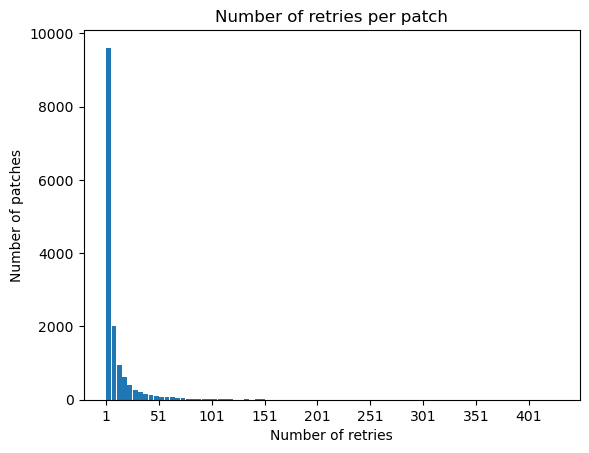

In [31]:
%matplotlib inline

retries = np.array(retries)
print(f"Total number of retries: {np.sum(retries)}")
print(f"Average number of retries: {np.mean(retries):.3f}")
print(f"Max number of retries: {np.max(retries)}")

# Plot histogram of number of retries
plt.hist(retries[retries > 0], bins=np.max(retries) // 5, rwidth=0.9)
plt.xticks(range(1, np.max(retries), 50))
plt.title("Number of retries per patch")
plt.xlabel("Number of retries")
plt.ylabel("Number of patches")
plt.show()

Display an image and its bounding boxes.

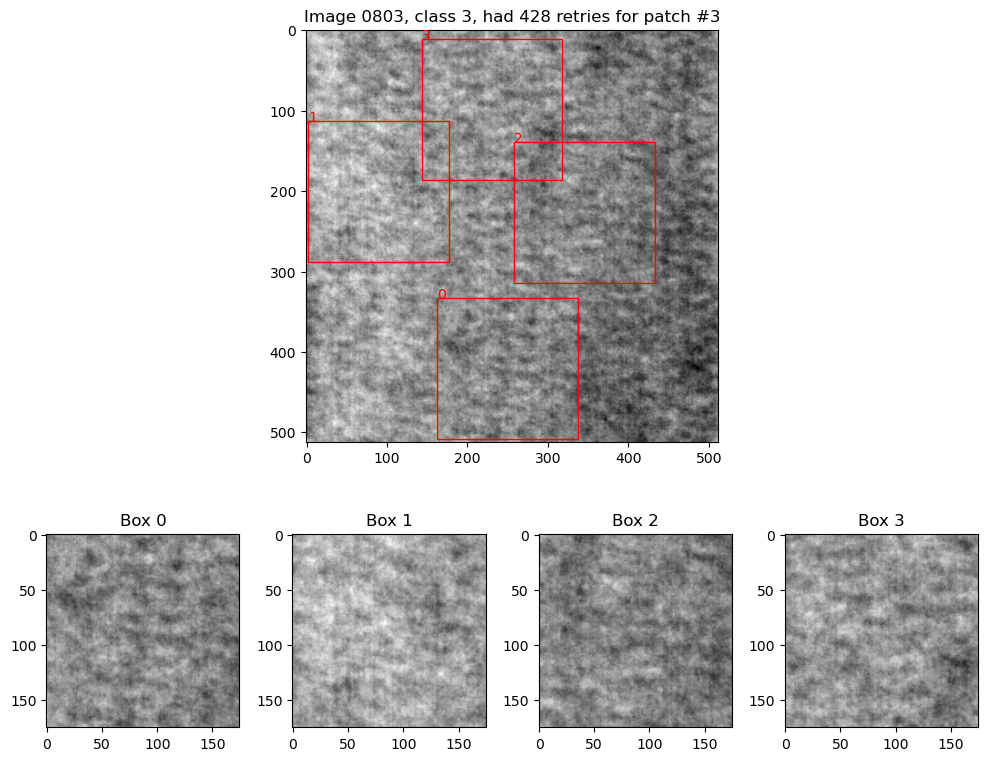

In [40]:
# Choose the image with the most retries
arg_max_retries = np.argmax(retries)
image, label, cls, name = dagm_ds[arg_max_retries // config.ppi]

image_cls = cls
image_name = name
patches_dir = os.path.join(
    config.DAGM_processed_dir, f"{config.ppi}ppi_{config.raw_patch_size}px", f"Class{image_cls}", "Train"
)
bboxes: list[TBBox] = []
for i in range(config.ppi):
    patch_path = os.path.join(patches_dir, f"{image_name}_{i}_*.png")
    patch_path = glob.glob(patch_path)[0]
    tl_x = int(patch_path.split("_")[-2])
    tl_y = int(patch_path.split("_")[-1].split(".")[0])
    bboxes.append((tl_x, tl_y, tl_x + config.raw_patch_size - 1, tl_y + config.raw_patch_size - 1))

image = (
    read_image(os.path.join(config.DAGM_raw_dir, f"Class{image_cls}", "Train", f"{image_name}.png")).squeeze(0).numpy()
)
show_image_with_bboxes(
    image,
    bboxes,
    title=f"Image {image_name}, class {cls}, had {retries[arg_max_retries]} retries for patch #{arg_max_retries % config.ppi}",
)